# SKLearn workflow
In sklearn, the machine learning workflow typically involves the following steps:
1. load data;
2. preprocess data;
3. train model;
4. evaluate model;
5. tune model;
6. deploy model.

The workflow is described in detail in the following:
1. Load data: You can use the sklearn or other libraries to load your dataset, such as load the classical dataset of Iris through `dataset.load_iris()`, or separate the dataset through `train_test_split()` function.
2. Preprocess data: According the type of data, you may need to nomalize, standardize, decrease the noise, fill the missing values, or convert categorical variables into numerical variables. Sklearn provides many preprocessing functions, such as `StandardScaler()`, `MinMaxScaler()`, `OneHotEncoder()`, etc.
3. Train model: Choose a suitable machine learning algorithm according to the problem type (classification, regression, clustering, etc.) and use the training data to train the model. Sklearn provides many algorithms, such as `LogisticRegression()`, `RandomForestClassifier()`, `KMeans()`, etc.
4. Evaluate model: Use the test data to evaluate the performance of the model. Sklearn provides many evaluation metrics, such as `accuracy_score()`, `mean_squared_error()`, `confusion_matrix()`, etc.
5. Tune model: Adjust the hyperparameters of the model to improve its performance. Sklearn provides many hyperparameter tuning methods, such as `GridSearchCV()`, `RandomizedSearchCV()`, etc.
6. Deploy model: Save the trained model and deploy it to a production environment for real-world applications. Sklearn provides the `joblib` library to save and load models.

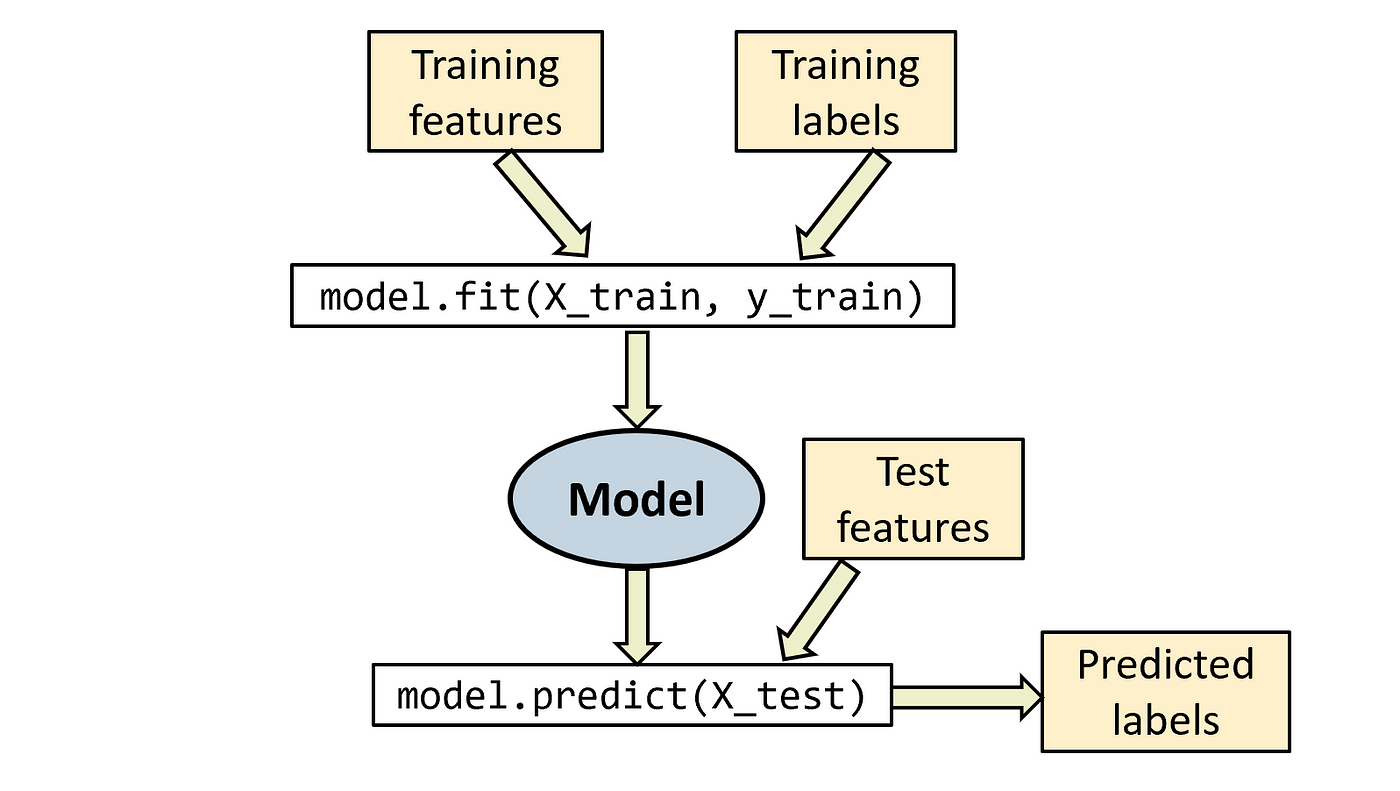

In [1]:
import sklearn
print(sklearn.__version__)

1.6.1


In [ ]:
import numpy as np
X = np.array([[1.0, 2.0], [2.0, 3.0], [3.0, 4.0]])

In [2]:
import numpy as np

from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [3]:
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.422s	69545	0.598	0.645	0.621	0.469	0.617	0.153
random   	0.028s	69735	0.681	0.723	0.701	0.574	0.698	0.178
PCA-based	0.010s	69513	0.600	0.647	0.622	0.468	0.618	0.154
__________________________________________________________________________________


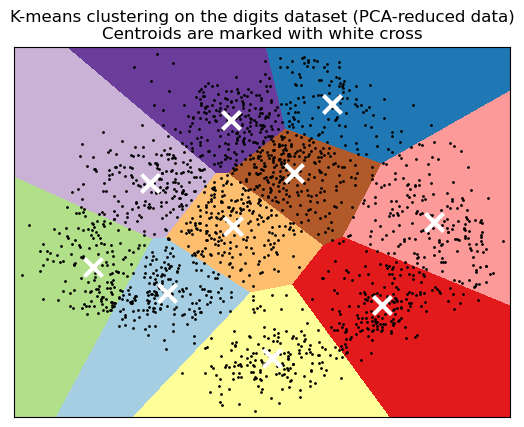

In [6]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Compute structured hierarchical clustering...
Elapsed time: 0.169s
Number of pixels: 4697
Number of clusters: 27


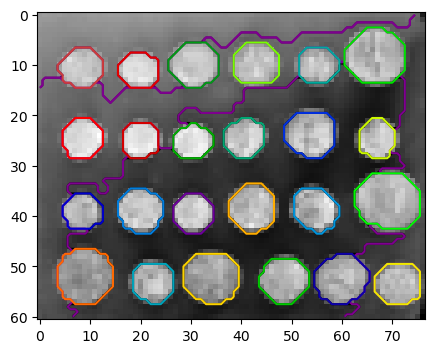

In [9]:
from skimage.data import coins

orig_coins = coins()



import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale

smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(
    smoothened_coins,
    0.2,
    mode="reflect",
    anti_aliasing=False,
)

X = np.reshape(rescaled_coins, (-1, 1))






from sklearn.feature_extraction.image import grid_to_graph

connectivity = grid_to_graph(*rescaled_coins.shape)







import time as time

from sklearn.cluster import AgglomerativeClustering

print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 27  # number of regions
ward = AgglomerativeClustering(
    n_clusters=n_clusters, linkage="ward", connectivity=connectivity
)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_coins.shape)
print(f"Elapsed time: {time.time() - st:.3f}s")
print(f"Number of pixels: {label.size}")
print(f"Number of clusters: {np.unique(label).size}")







import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(
        label == l,
        colors=[
            plt.cm.nipy_spectral(l / float(n_clusters)),
        ],
    )
# plt.axis("off")
plt.show()

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import numpy as np

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)